# Loading required packages and data

In [1]:
library(Seurat)
library(SeuratDisk)
library(future)

library(here)
library(tidyverse)
library(ggpubr)

library(caret)
library(cluster)
library(hash)

ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F)
options(repr.plot.width=11, repr.plot.height=8.5)

#######################################################
# 0) Seurat uses the future package for parallelization
## set to be parallel over 28 cores
plan("multicore", workers = 28)
options(future.globals.maxSize = 100 * 1024^3)
options(future.rng.onMisuse = 'ignore')

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

here() starts at /projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘packag

In [13]:
library(ggridges)
library(ggplot2)

In [2]:
#genes used in xenium panel
mouse_panel = read.csv('/projects/pfenninggroup/spatial/resources/panels/original_mouse_brain_markers.csv')

In [4]:
# load russ et al data
filename = "/home/vijaykic/BaDoi/data/tidy_data/rdas/final_cluster_assignment.h5seurat"
mouse_rna = LoadH5Seurat(filename)
mouse_rna = mouse_rna[, mouse_rna$dataset == 'Sathyamurthy']
mouse_rna <- subset(x = mouse_rna, features = unique(mouse_panel$Genes) )
mouse_rna = mouse_rna[,mouse_rna$nCount_RNA > 0]

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing integrated with data

Adding scale.data for integrated

Adding variable feature information for integrated

Adding miscellaneous information for integrated

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results

Adding data that was not associated with an assay

Warning message:
“Adding a command log without an assay associated with it”
Warning message:
“Adding a command log without an assay associated with it”
Warning message:
“Adding a command log without an assay associated with it”


In [5]:
DefaultAssay(mouse_rna) = 'RNA'

In [6]:
dplyr::glimpse(mouse_rna[[]])

Rows: 19,547
Columns: 8
$ nCount_RNA               <dbl> 15, 12, 11, 36, 190, 131, 28, 17, 18, 152, 8,…
$ nFeature_RNA             <int> 13, 11, 10, 28, 53, 48, 19, 16, 16, 45, 7, 5,…
$ orig.ident               <chr> "SRR6040902", "SRR6040902", "SRR6040902", "SR…
$ percent.mt               <dbl> 0.0009276438, 0.0000000000, 0.0037974684, 0.0…
$ dataset                  <chr> "Sathyamurthy", "Sathyamurthy", "Sathyamurthy…
$ final_cluster_assignment <chr> "Oligos.2", "Oligos.1", "Meninges.1", "Oligos…
$ coarse_cell_types        <chr> "Oligos", "Oligos", "Meninges", "Oligos", "In…
$ family                   <chr> "Oligos.2", "Oligos.1", "Meninges.1", "Oligos…


In [7]:
table(mouse_rna$coarse_cell_types)


 Astrocytes         CSF Endothelial   Ependymal       Excit       Inhib 
       2662          31        1075         468        2968        2425 
   Meninges   Microglia          MN       Oligo      Oligos         OPC 
       2302         466          40         226        4627         322 
  Pericytes  Peripheral         PGC     Schwann 
        463         298           9        1165 

In [8]:
mouse_rna$coarse_MN_subtypes <- mouse_rna$coarse_cell_types
mouse_rna$coarse_MN_subtypes[mouse_rna$final_cluster_assignment == 'MN.alpha'] = 'MN.alpha'
mouse_rna$coarse_MN_subtypes[mouse_rna$final_cluster_assignment == 'MN.gamma'] = 'MN.gamma'

In [9]:
table(mouse_rna$coarse_MN_subtypes)


 Astrocytes         CSF Endothelial   Ependymal       Excit       Inhib 
       2662          31        1075         468        2968        2425 
   Meninges   Microglia    MN.alpha    MN.gamma       Oligo      Oligos 
       2302         466          28          12         226        4627 
        OPC   Pericytes  Peripheral         PGC     Schwann 
        322         463         298           9        1165 

In [10]:
mouse_rna

An object of class Seurat 
427 features across 19547 samples within 2 assays 
Active assay: RNA (241 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

In [11]:
dplyr::glimpse(mouse_rna[])

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 2
  .. ..$ integrated:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  .. ..$ RNA       :Formal class 'Assay' [package "SeuratObject"] with 8 slots
  ..@ meta.data   :'data.frame':	19547 obs. of  9 variables:
  .. ..$ nCount_RNA              : num [1:19547] 15 12 11 36 190 131 28 17 18 152 ...
  .. ..$ nFeature_RNA            : int [1:19547] 13 11 10 28 53 48 19 16 16 45 ...
  .. ..$ orig.ident              : chr [1:19547] "SRR6040902" "SRR6040902" "SRR6040902" "SRR6040902" ...
  .. ..$ percent.mt              : num [1:19547] 0.000928 0 0.003797 0.001662 0.00016 ...
  .. ..$ dataset                 : chr [1:19547] "Sathyamurthy" "Sathyamurthy" "Sathyamurthy" "Sathyamurthy" ...
  .. ..$ final_cluster_assignment: chr [1:19547] "Oligos.2" "Oligos.1" "Meninges.1" "Oligos.2" ...
  .. ..$ coarse_cell_types       : chr [1:19547] "Oligos" "Oligos" "Meninges" "Oligos" ...
  .. ..$ family         

# The goal is to find cell types from the rna-seq data that have high Chat, Prph and Nrp2 gene expression. To do this, I plot ridgeplots of cell types vs gene expression levels for that particular gene taken from the scRNA-seq data

In [14]:
#choose a gene row from mouse_rna
gene_name = 'Chat'
gene_values <- mouse_rna[['RNA']]$data[gene_name, ]

In [15]:
length(gene_values)

[1] 19547

In [16]:
#take the cell-type annotations

cell_anno <- mouse_rna$coarse_MN_subtypes
length(cell_anno)


[1] 19547

In [19]:
sub_mouse_rna <- data.frame(Chat = gene_values, Anno = cell_anno)

In [20]:
dim(sub_mouse_rna)

[1] 19547     2

Picking joint bandwidth of 0.125



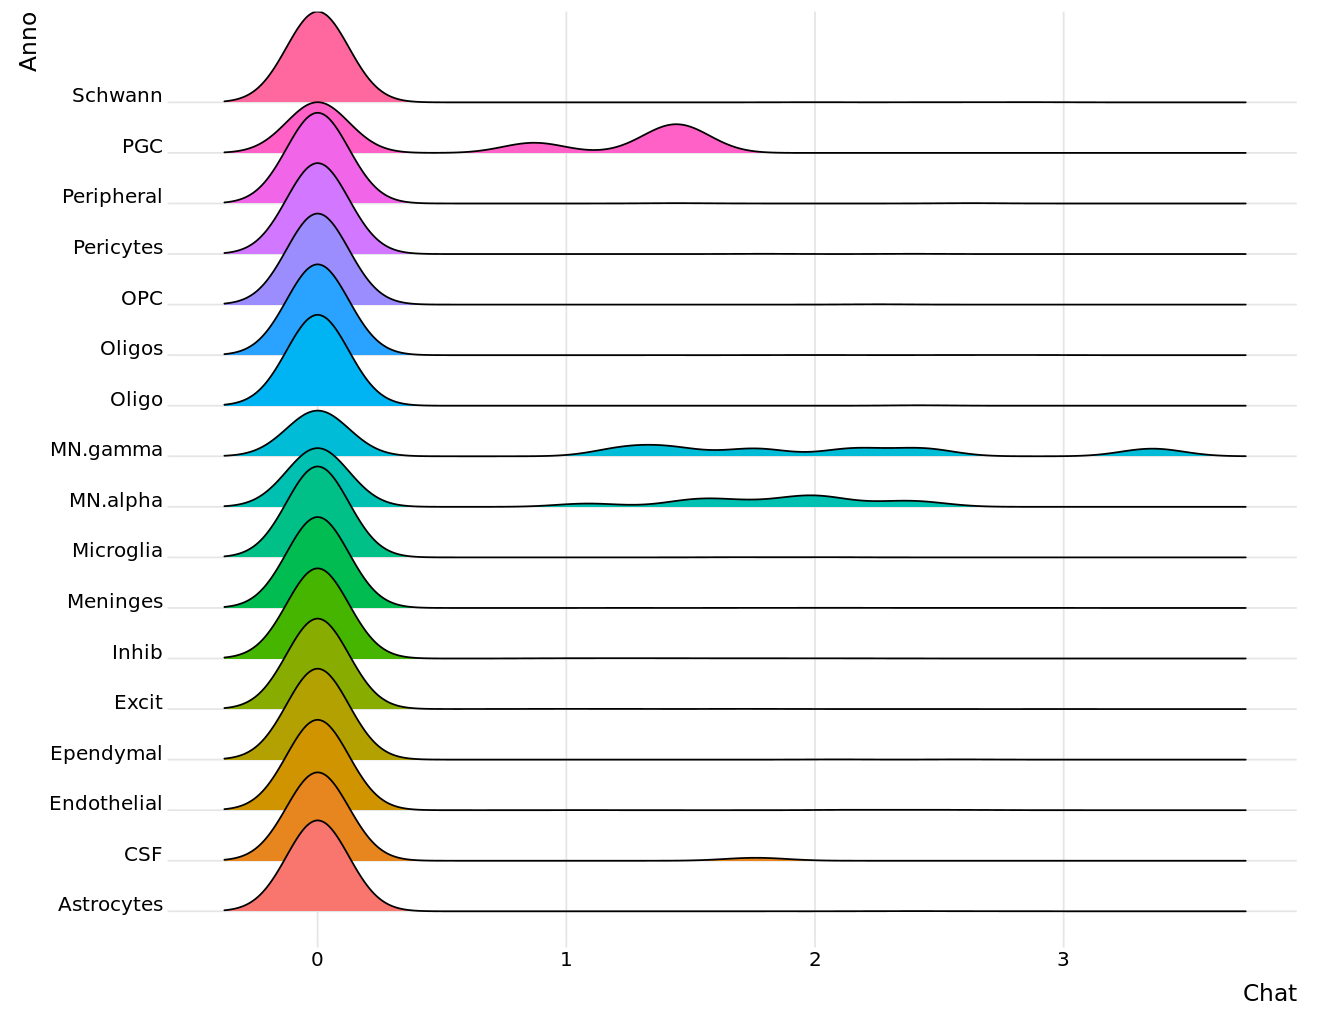

In [21]:
ggplot(sub_mouse_rna, aes(x = Chat, y = Anno, fill = Anno)) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none")

In [22]:
sub_mouse_rna$Prph <- mouse_rna[['RNA']]$data['Prph', ]

Picking joint bandwidth of 0.176



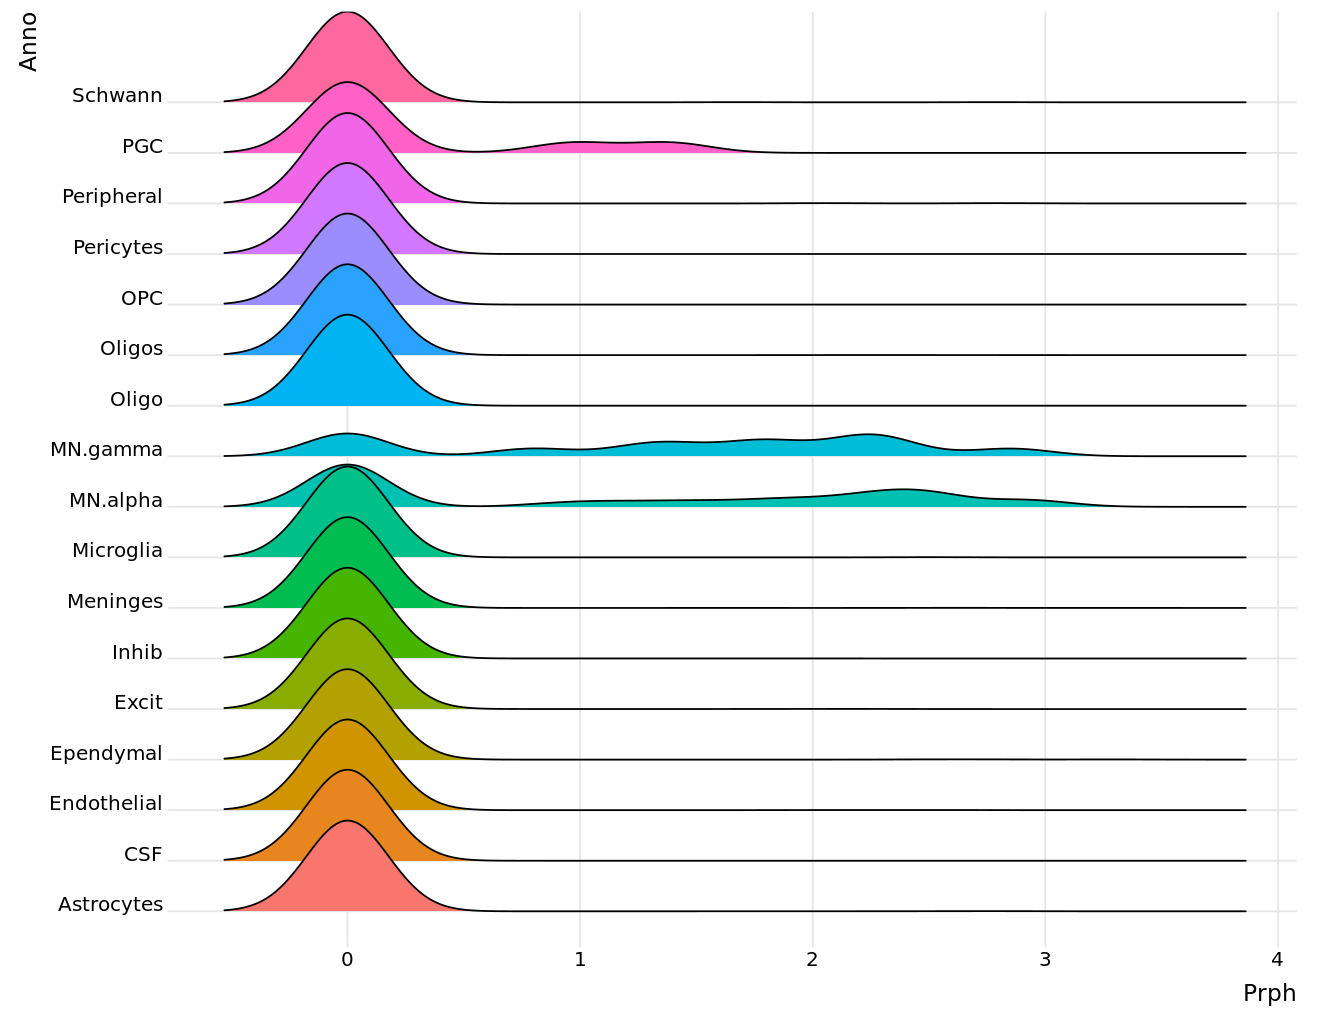

In [23]:
ggplot(sub_mouse_rna, aes(x = Prph, y = Anno, fill = Anno)) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none")

In [24]:
sub_mouse_rna$Nrp2 <- mouse_rna[['RNA']]$data['Nrp2', ]

Picking joint bandwidth of 0.247



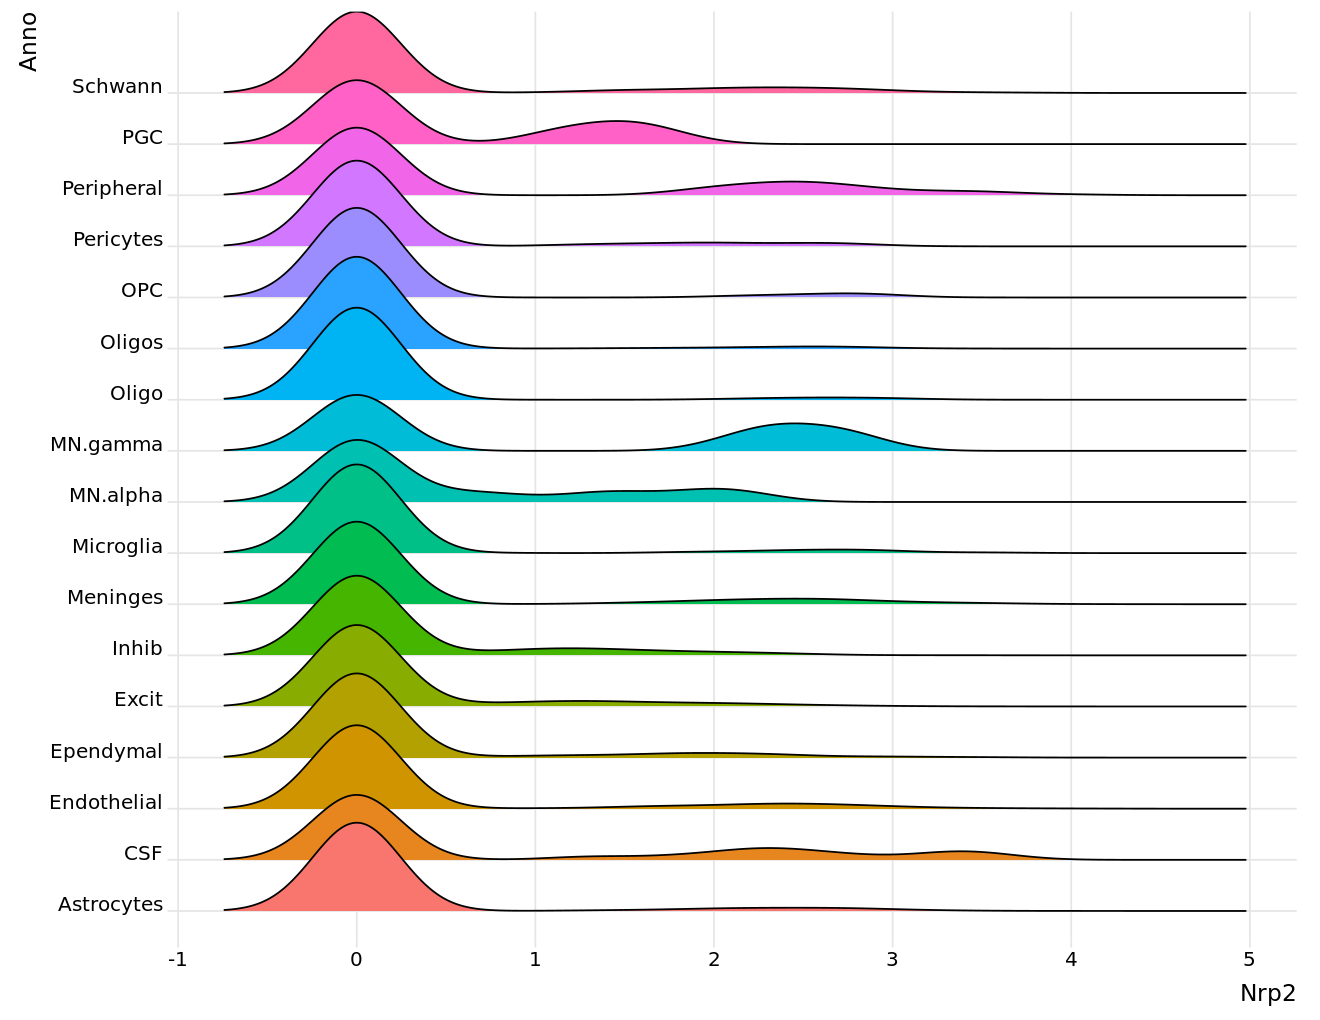

In [25]:
ggplot(sub_mouse_rna, aes(x = Nrp2, y = Anno, fill = Anno)) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none")

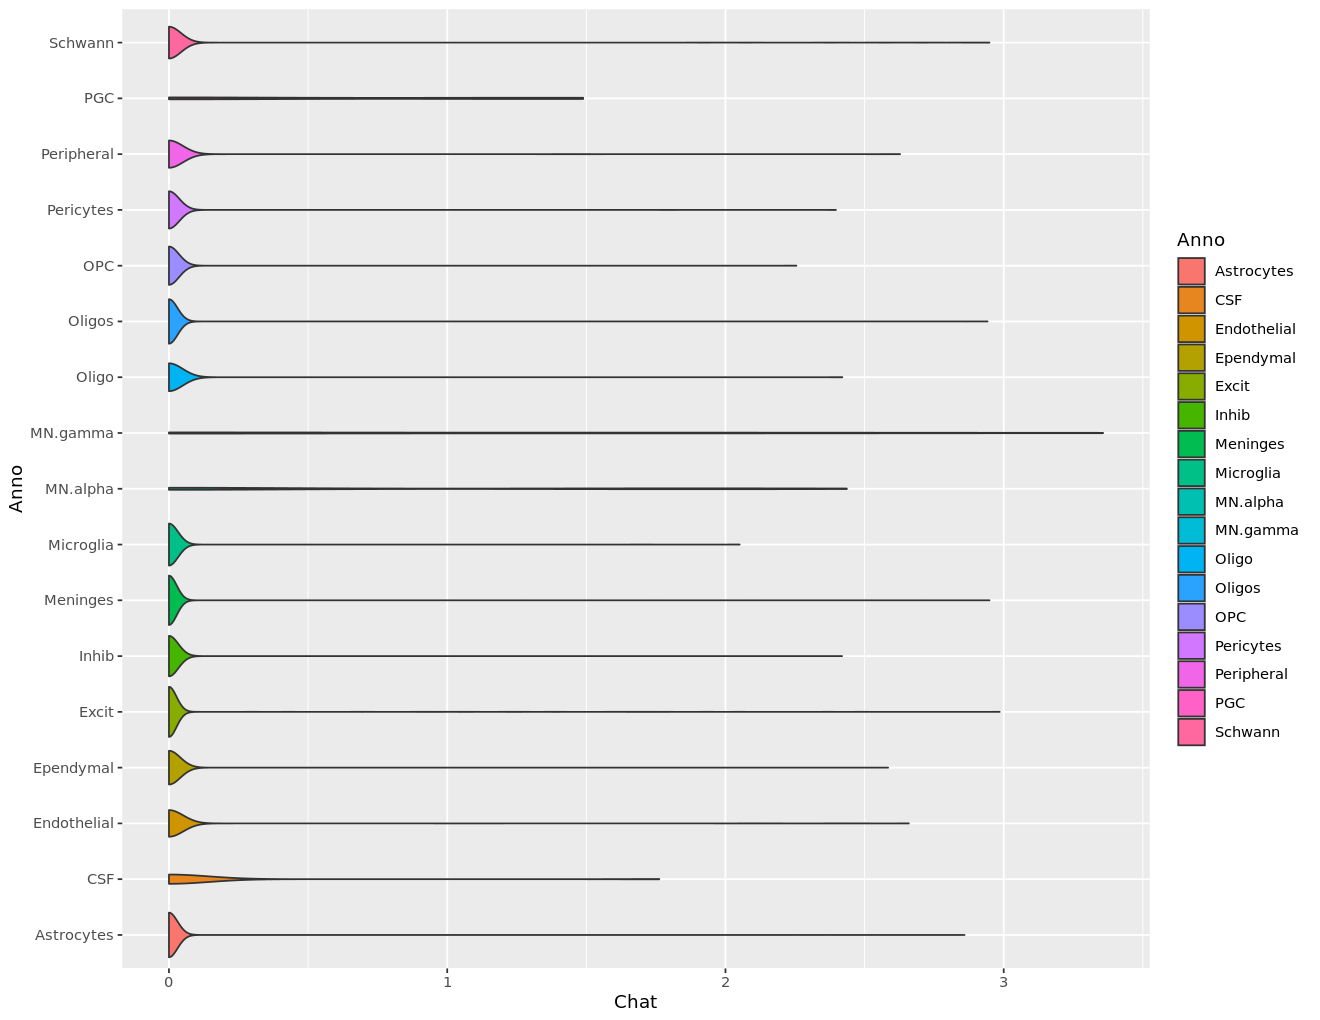

In [34]:
ggplot(sub_mouse_rna, aes(x = Chat, y = Anno, fill = Anno)) + 
  geom_violin()

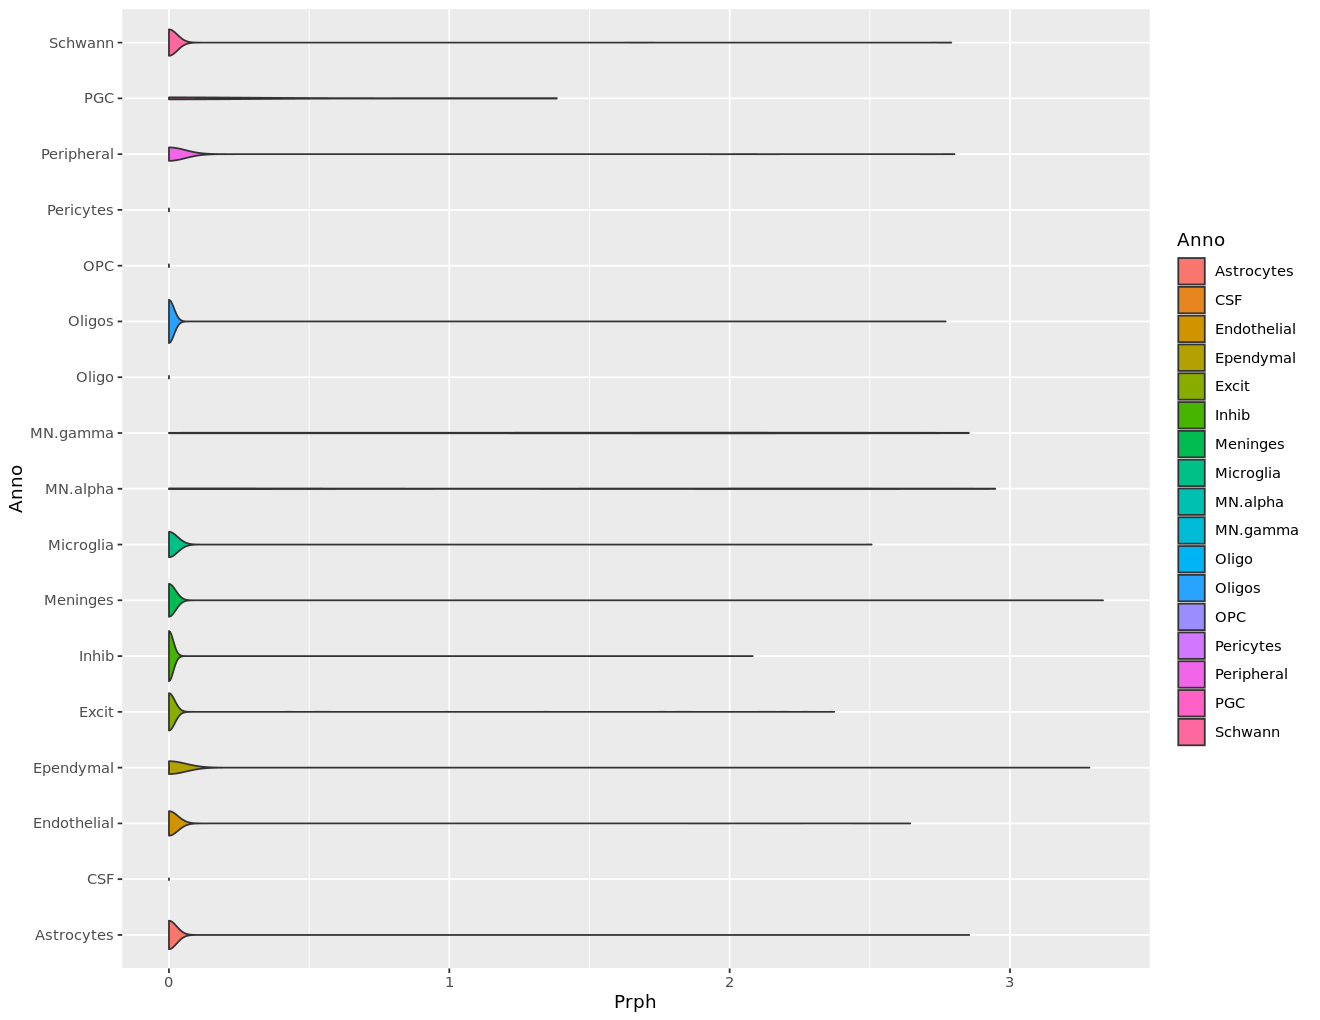

In [35]:
ggplot(sub_mouse_rna, aes(x = Prph, y = Anno, fill = Anno)) + 
  geom_violin()

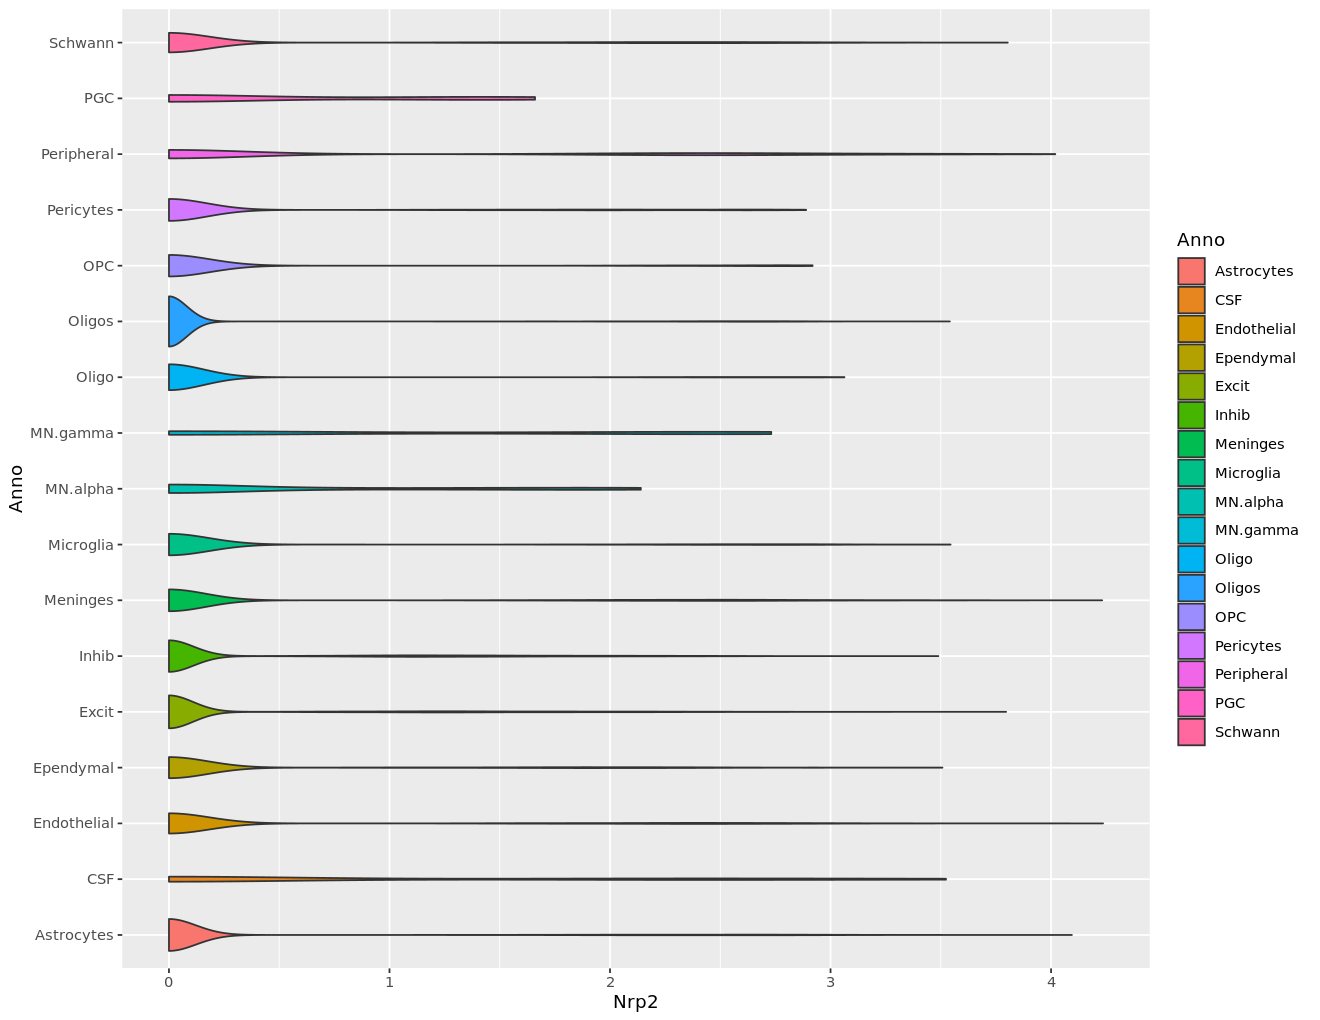

In [36]:
ggplot(sub_mouse_rna, aes(x = Nrp2, y = Anno, fill = Anno)) + 
  geom_violin()

Additionally, I created violin plots of the same data to determine if this visualization method provides clearer insights compared to ridge plots.

# The cell types of interest were found to be PGC and motor neurons (alpha and gamma).